In [1]:
import os
import tensorflow as tf
from tensorflow import keras
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
from itertools import combinations
from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix, accuracy_score
from google.colab import drive, files
drive.mount('/content/drive')

from keras import layers, models, Input, optimizers, initializers, regularizers, metrics
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import RMSprop, Adam
from keras.models import Model, load_model, Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.applications import VGG16, VGG19, InceptionV3, resnet, xception, densenet

from tensorflow.keras.layers import Activation, Dropout, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Input, SeparableConv2D
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D, MaxPooling2D,  ZeroPadding2D

%matplotlib inline

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

Mounted at /content/drive


In [2]:
import random

random.seed(36)
np.random.seed(36)
tf.random.set_seed(36)

In [3]:
base_dir = '/content/drive/My Drive/Xray_data/'

In [4]:
from google.colab import files


def plot_result(hist, cf_mat, test_res):
    hist_dict = hist.history
    acc = hist_dict['acc']
    val_acc = hist_dict['val_acc']
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    epochs = range(1, len(acc) + 1)
    epochs_num = epochs[-1]

    total_acc = test_res[1]
    recall_nor_vs = (cf_mat[1][1] + cf_mat[2][1] + cf_mat[1][2] + cf_mat[2][2]) / (
        cf_mat[1][1] + cf_mat[2][1] + cf_mat[1][2] + cf_mat[2][2] + cf_mat[1][0] + cf_mat[2][0])
    precision_nor_vs = (cf_mat[1][1] + cf_mat[2][1] + cf_mat[1][2] + cf_mat[2][2]) / (
        cf_mat[1][1] + cf_mat[2][1] + cf_mat[1][2] + cf_mat[2][2] + cf_mat[0][1] + cf_mat[0][2])
    f1_score_nor_vs = 2*recall_nor_vs*precision_nor_vs / \
        (recall_nor_vs + precision_nor_vs)

    acc_cov_pne = (cf_mat[1][1] + cf_mat[2][2]) / (cf_mat[1]
                                                   [1] + cf_mat[2][1] + cf_mat[1][2] + cf_mat[2][2])
    recall_cov_pne = cf_mat[2][2] / (cf_mat[2][1] + cf_mat[2][2])
    perf_y = [total_acc, recall_nor_vs, precision_nor_vs,
              f1_score_nor_vs, acc_cov_pne, recall_cov_pne]
    perf_x = ['acc(total)', 'recall(nor vs)', 'precision(nor vs)',
              'f1(nor vs)', 'acc(cov&pne)', 'recall(cov&pne)']

    plt.style.use(['seaborn'])
    fig = plt.figure(figsize=(18, 5))

    if epochs_num//5 < 1:
        x_interval = 1
    else:
        x_interval = epochs_num//5

    fig.add_subplot(1, 3, 1)
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy', size=18)
    plt.xlabel('Epochs', size=14)
    plt.xticks(list(range(1, epochs_num+1, x_interval)))
    plt.ylabel('Accuracy', size=14)
    plt.legend()

    ax2 = fig.add_subplot(1, 3, 2)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss', size=18)
    plt.xlabel('Epochs', size=14)
    plt.xticks(list(range(1, epochs_num+1, x_interval)))
    plt.ylabel('Accuracy', size=14)
    plt.legend()

    ax3 = fig.add_subplot(1, 3, 3)
    plt.plot(perf_x, perf_y)
    plt.title('Model performance evaluation', size=18)
    plt.xticks(size=12, rotation=45)
    plt.show()


def true_label_ftn(label_):
    tr_label = []
    for i in label_:
        for th, j in enumerate(i):
            if j == 1:
                tr_label.append(th)

    return np.array(tr_label)


def print_result(res_name, res, per=0):
    if per:
        print('{0:^35} |  {1:0.4f}'.format(res_name, res))
    else:
        print('{0:^35} |  {1:0.2f}%'.format(res_name, res*100))


def model_performance(mod, hist, data_, label_, model_name=''):

    test_results = mod.evaluate(data_, label_, verbose=0)
    tr_label = true_label_ftn(label_)
    pred_c = mod.predict(data_)
    pred_c = np.argmax(pred_c, axis=1)

    index_list = ['NORMAL', 'PNEUMONIA', 'COVID19']
    cf_mat = confusion_matrix(tr_label, pred_c)
    cf_df = pd.DataFrame(cf_mat, index=index_list, columns=index_list)

    print('\n')
    plot_result(hist, cf_mat, test_results)
    print('\n')

    fig = plt.figure(figsize=(8, 7))
    sns.heatmap(cf_df, annot=True, cmap='Blues',
                fmt='d', annot_kws={"size": 14})
    plt.title('Confusion Matrix', fontsize=18)
    plt.xlabel('Predicted label', fontsize=16)
    plt.ylabel('True label', fontsize=16)

    plt.show()

    save_perform = hist.history
    save_perform['cf_mat'] = cf_mat
    save_perform['mod_eval'] = test_results
    if model_name == '':
        np.save('model_performance_save', np.array(save_perform))
        files.download('model_performance_save.npy')
    else:
        np.save('{0}_performance_savefile'.format(
            model_name), np.array(save_perform))
        files.download('{0}_performance_savefile'.format(model_name)+'.npy')

In [5]:
train_data = np.load(base_dir + 'train_data128_pre.npy')
test_data = np.load(base_dir + 'test_data128_pre.npy')

In [6]:
train_label = np.load(base_dir + 'train_label128_pre.npy')
test_label = np.load(base_dir + 'test_label128_pre.npy')

# 1. Models

Model: "3ConvLayer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 12544)             0

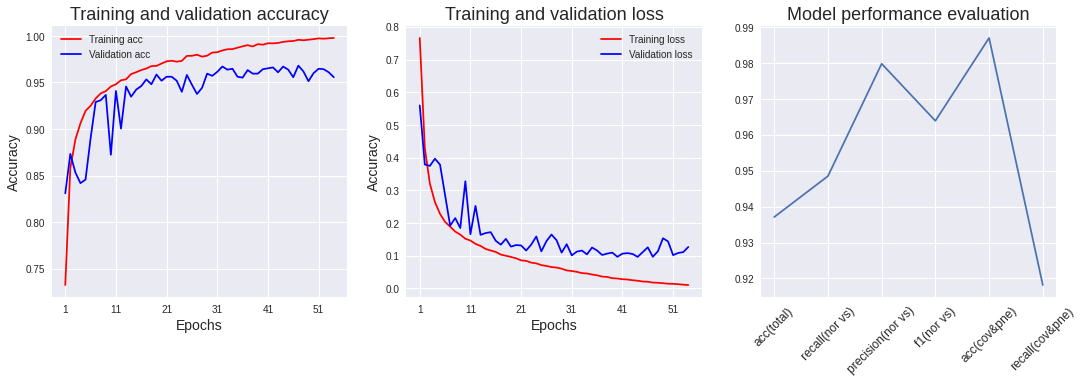

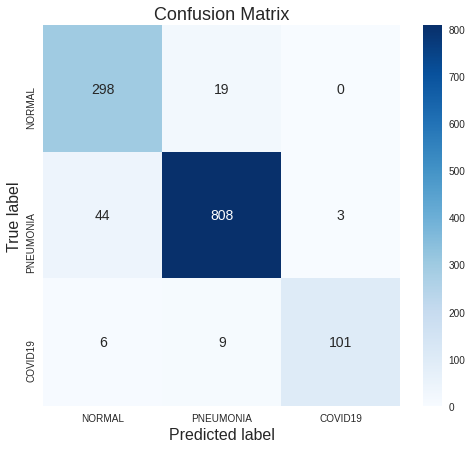

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# 3ConvLayer model

conv3_model = models.Sequential(name="3ConvLayer")
conv3_model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(128, 128, 3)))
conv3_model.add(layers.MaxPooling2D(2,2))
conv3_model.add(layers.Conv2D(32, (3,3), activation='relu'))
conv3_model.add(layers.MaxPooling2D(2,2))
conv3_model.add(layers.Conv2D(64, (3,3), activation='relu'))
conv3_model.add(layers.MaxPooling2D(2,2))
conv3_model.add(layers.Flatten())
conv3_model.add(Dense(512, activation='relu'))
conv3_model.add(Dense(64, activation='relu'))
conv3_model.add(Dense(3, activation='softmax'))

conv3_model.summary()

conv3_model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

earlystopping = EarlyStopping(monitor='val_loss', verbose=1, patience=10)

history = conv3_model.fit(train_data, 
                          train_label,
                          validation_split=0.2,
                          epochs=300,
                          callbacks=[earlystopping])

model_performance(conv3_model, history, test_data, test_label, '3ConvLayer')

58892288/58889256 [==============================] - 0s 0us/step
Model: "VGG16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 4096)              33558528  
_________________________________________________________________
dense_4 (Dense)              (None, 512)               2097664   
_________________________________________________________________
dense_5 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_6 (Dense)              (None, 3)                 195       
Total params: 50,403,907
Trainable params: 50,403,907
Non-trai

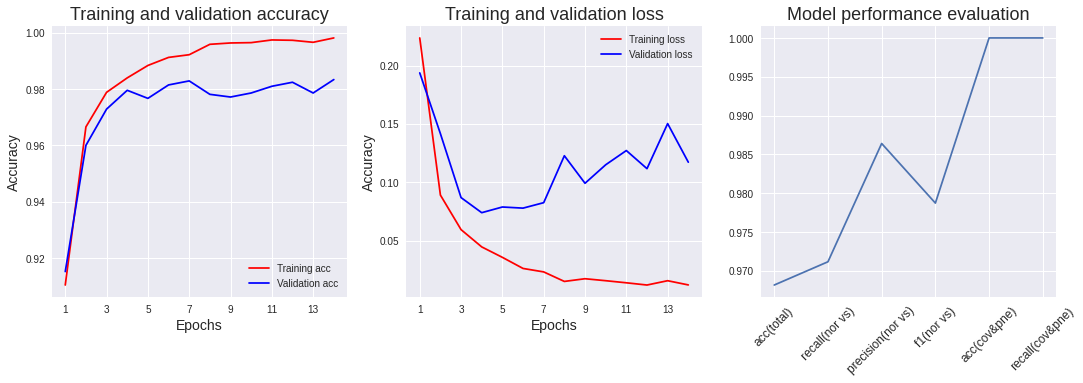

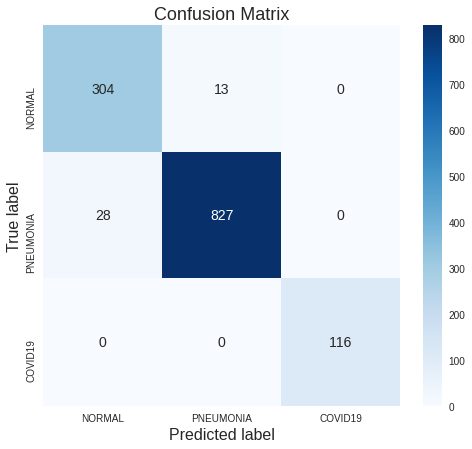

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# vgg16

vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

vgg16_model = models.Sequential(name='VGG16')
vgg16_model.add(vgg16)
vgg16_model.add(layers.Flatten())
vgg16_model.add(layers.Dense(4096, activation='relu'))
vgg16_model.add(layers.Dense(512, activation='relu'))
vgg16_model.add(layers.Dense(64, activation='relu'))
vgg16_model.add(layers.Dense(3, activation='softmax'))

vgg16_model.summary()

vgg16_model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = vgg16_model.fit(train_data, 
                          train_label,
                          validation_split=0.2,
                          epochs=200,
                          callbacks=[earlystopping])

model_performance(vgg16_model, history, test_data, test_label, 'VGG16')

80142336/80134624 [==============================] - 2s 0us/step
Model: "VGG19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 4096)              33558528  
_________________________________________________________________
dense_8 (Dense)              (None, 512)               2097664   
_________________________________________________________________
dense_9 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 195       
Total params: 55,713,603
Trainable params: 55,713,603
Non-trai

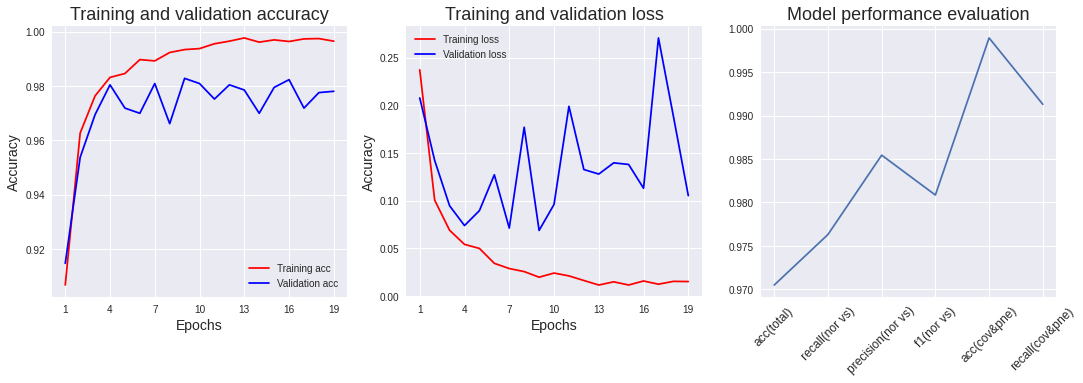

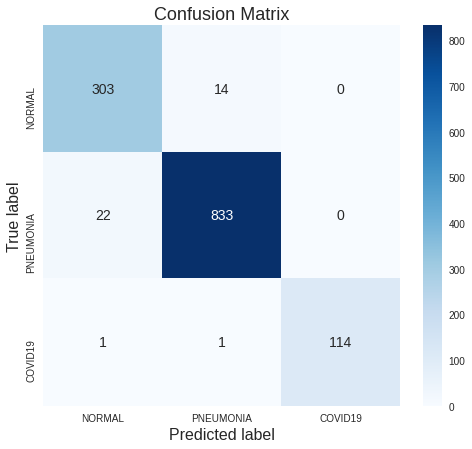

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# vgg19

vgg19 = VGG19(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

vgg19_model = models.Sequential(name='VGG19')
vgg19_model.add(vgg19)
vgg19_model.add(layers.Flatten())
vgg19_model.add(layers.Dense(4096, activation='relu'))
vgg19_model.add(layers.Dense(512, activation='relu'))
vgg19_model.add(layers.Dense(64, activation='relu'))
vgg19_model.add(layers.Dense(3, activation='softmax'))

vgg19_model.summary()

vgg19_model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = vgg19_model.fit(train_data, 
                          train_label,
                          validation_split=0.2,
                          epochs=200,
                          callbacks=[earlystopping])

model_performance(vgg19_model, history, test_data, test_label, 'VGG19')

Model: "AlexNet"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 30, 30, 96)        34944     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 14, 14, 96)        384       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 256)       614656    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 5, 5, 256)         0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 5, 5, 256)         1024      
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 5, 5, 384)         8851

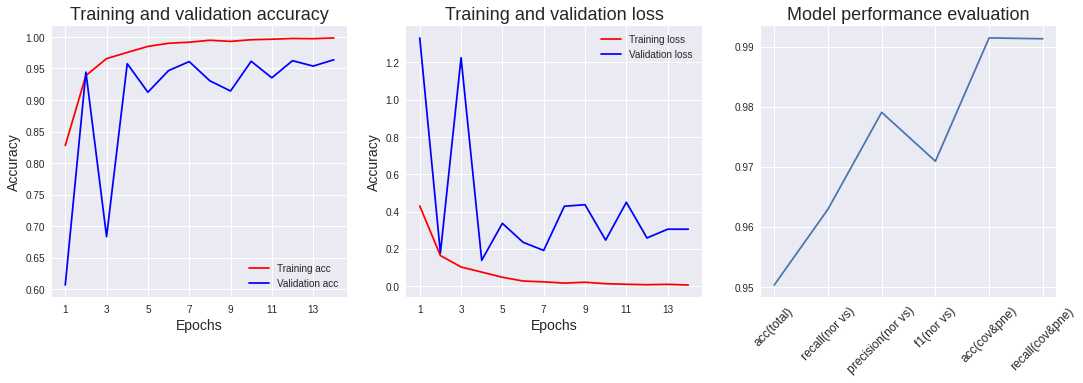

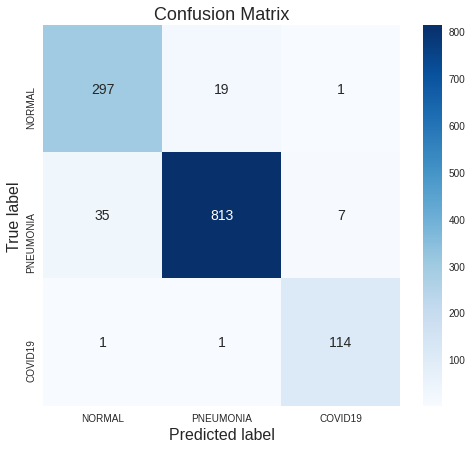

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# AlexNet

alexnet_model = Sequential(name='AlexNet')
alexnet_model.add(Conv2D(filters = 96, input_shape = (128,128,3), kernel_size=(11,11), strides=(4,4), activation = 'relu'))
alexnet_model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2)))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation = 'relu'))
alexnet_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
alexnet_model.add(BatchNormalization())
alexnet_model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='SAME', activation = 'relu'))
alexnet_model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='SAME', activation = 'relu'))
alexnet_model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='SAME', activation = 'relu'))
alexnet_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))
alexnet_model.add(Flatten())
alexnet_model.add(Dense(4096, activation = 'relu'))
alexnet_model.add(Dropout(0.5))
alexnet_model.add(Dense(4096, activation = 'relu'))
alexnet_model.add(Dropout(0.5))
alexnet_model.add(Dense(512, activation = 'relu'))
alexnet_model.add(Dense(64, activation = 'relu'))
alexnet_model.add(Dense(3, activation = 'softmax'))

alexnet_model.summary()

alexnet_model.compile(loss = 'categorical_crossentropy', optimizer = optimizers.RMSprop(lr=2e-5), metrics = ['acc'])

history = alexnet_model.fit(train_data, 
                          train_label,
                          validation_split=0.2,
                          epochs=200,
                          callbacks=[earlystopping])

model_performance(alexnet_model, history, test_data, test_label, 'AlexNet')

Model: "ResNet34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 64, 64, 64)        9408      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 64)        0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 32, 32, 64)        0         
_________________________________________________________________
residual_unit (ResidualUnit) (None, 32, 32, 64)        74240     
_________________________________________________________________
residual_unit_1 (ResidualUni (None, 32, 32, 64)        74240     
_________________________________________________________________
residual_unit_2 (ResidualUni (None, 32, 32, 64)        742

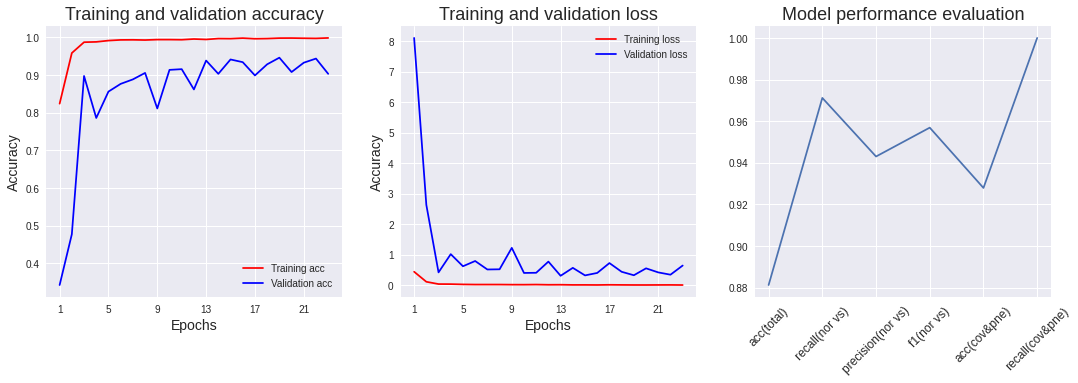

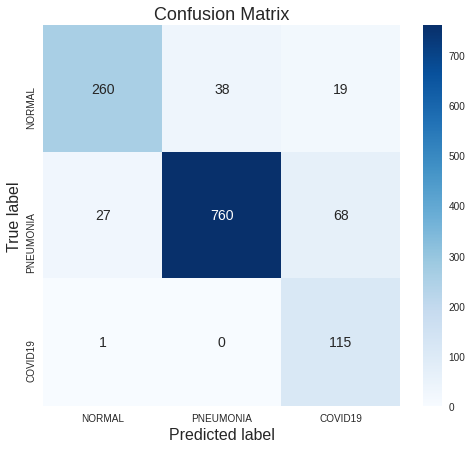

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Resnet34
from functools import partial
DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, strides=1,
                        padding="SAME", use_bias=False)

class ResidualUnit(keras.layers.Layer):
    def __init__(self, filters, strides=1, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.activation = keras.activations.get(activation)
        self.main_layers = [
            DefaultConv2D(filters, strides=strides),
            keras.layers.BatchNormalization(),
            self.activation,
            DefaultConv2D(filters),
            keras.layers.BatchNormalization()]
        self.skip_layers = []
        if strides > 1:
            self.skip_layers = [
                DefaultConv2D(filters, kernel_size=1, strides=strides),
                keras.layers.BatchNormalization()]

    def call(self, inputs):
        Z = inputs
        for layer in self.main_layers:
            Z = layer(Z)
        skip_Z = inputs
        for layer in self.skip_layers:
            skip_Z = layer(skip_Z)
        return self.activation(Z + skip_Z)

resnet34_model = models.Sequential(name='ResNet34')
resnet34_model.add(DefaultConv2D(64, kernel_size=7, strides=2,
                        input_shape=[128, 128, 3]))
resnet34_model.add(layers.BatchNormalization())
resnet34_model.add(layers.Activation("relu"))
resnet34_model.add(layers.MaxPool2D(pool_size=3, strides=2, padding="SAME"))
prev_filters = 64
for filters in [64] * 3 + [128] * 4 + [256] * 6 + [512] * 3:
    strides = 1 if filters == prev_filters else 2
    resnet34_model.add(ResidualUnit(filters, strides=strides))
    prev_filters = filters
resnet34_model.add(layers.GlobalAvgPool2D())
resnet34_model.add(layers.Flatten())
resnet34_model.add(layers.Dense(3, activation="softmax"))

resnet34_model.summary()

resnet34_model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = resnet34_model.fit(train_data, 
                          train_label,
                          validation_split=0.2,
                          epochs=200,
                          callbacks=[earlystopping])

model_performance(resnet34_model, history, test_data, test_label, 'ResNet34')

94773248/94765736 [==============================] - 1s 0us/step
Model: "ResNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten_5 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_17 (Dense)             (None, 4096)              134221824 
_________________________________________________________________
dense_18 (Dense)             (None, 512)               2097664   
_________________________________________________________________
dense_19 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 195       
Total params: 159,940,227
Trainable params: 159,887,107
Non

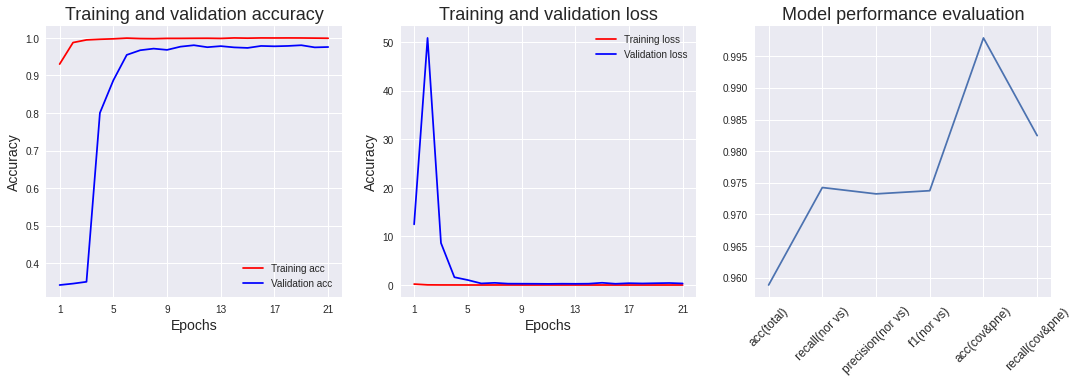

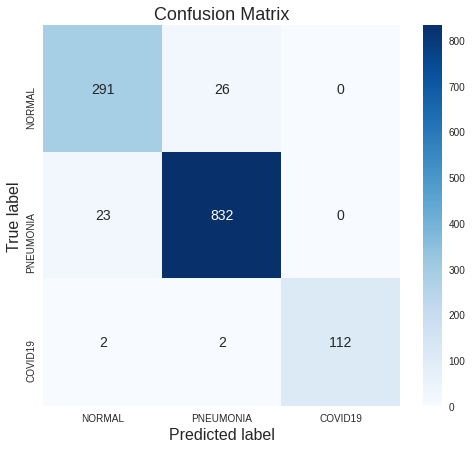

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# resnet50

resnet50 = resnet.ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

resnet50_model = models.Sequential(name="ResNet50")
resnet50_model.add(resnet50)
resnet50_model.add(layers.Flatten())
resnet50_model.add(layers.Dense(4096, activation='relu'))
resnet50_model.add(layers.Dense(512, activation='relu'))
resnet50_model.add(layers.Dense(64, activation='relu'))
resnet50_model.add(layers.Dense(3, activation='softmax'))

resnet50_model.summary()

resnet50_model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = resnet50_model.fit(train_data, 
                          train_label,
                          validation_split=0.2,
                          epochs=200,
                          callbacks=[earlystopping])

model_performance(resnet50_model, history, test_data, test_label, 'ResNet50')

29089792/29084464 [==============================] - 0s 0us/step
Model: "DenseNet50"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Functional)     (None, 4, 4, 1024)        7037504   
_________________________________________________________________
flatten_6 (Flatten)          (None, 16384)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 4096)              67112960  
_________________________________________________________________
dense_22 (Dense)             (None, 512)               2097664   
_________________________________________________________________
dense_23 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_24 (Dense)             (None, 3)                 195       
Total params: 76,281,155
Trainable params: 76,197,507
Non

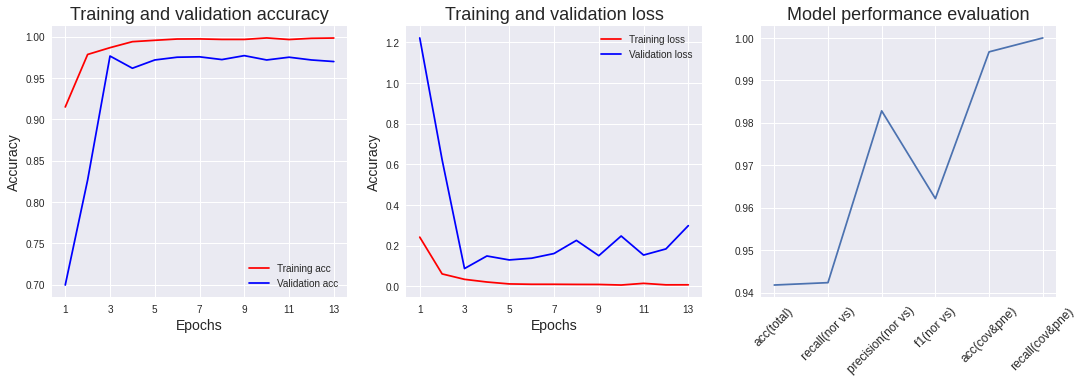

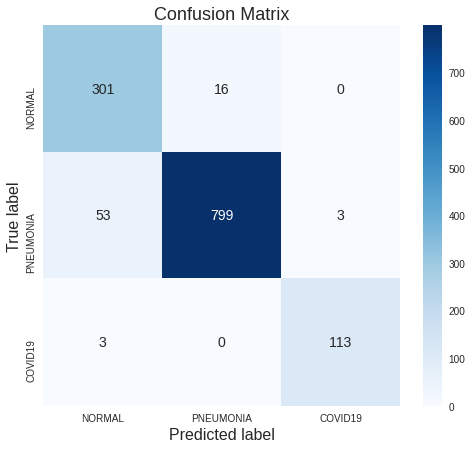

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# densenet50

densenet50 = densenet.DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

densenet50_model = models.Sequential(name='DenseNet50')
densenet50_model.add(densenet50)
densenet50_model.add(layers.Flatten())
densenet50_model.add(layers.Dense(4096, activation='relu'))
densenet50_model.add(layers.Dense(512, activation='relu'))
densenet50_model.add(layers.Dense(64, activation='relu'))
densenet50_model.add(layers.Dense(3, activation='softmax'))

densenet50_model.summary()

densenet50_model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = densenet50_model.fit(train_data, 
                          train_label,
                          validation_split=0.2,
                          epochs=200,
                          callbacks=[earlystopping])

model_performance(densenet50_model, history, test_data, test_label, 'DenseNet50')

83689472/83683744 [==============================] - 1s 0us/step
Model: "Xception"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Functional)        (None, 4, 4, 2048)        20861480  
_________________________________________________________________
flatten_7 (Flatten)          (None, 32768)             0         
_________________________________________________________________
dense_25 (Dense)             (None, 4096)              134221824 
_________________________________________________________________
dense_26 (Dense)             (None, 512)               2097664   
_________________________________________________________________
dense_27 (Dense)             (None, 64)                32832     
_________________________________________________________________
dense_28 (Dense)             (None, 3)                 195       
Total params: 157,213,995
Trainable params: 157,159,467
Non

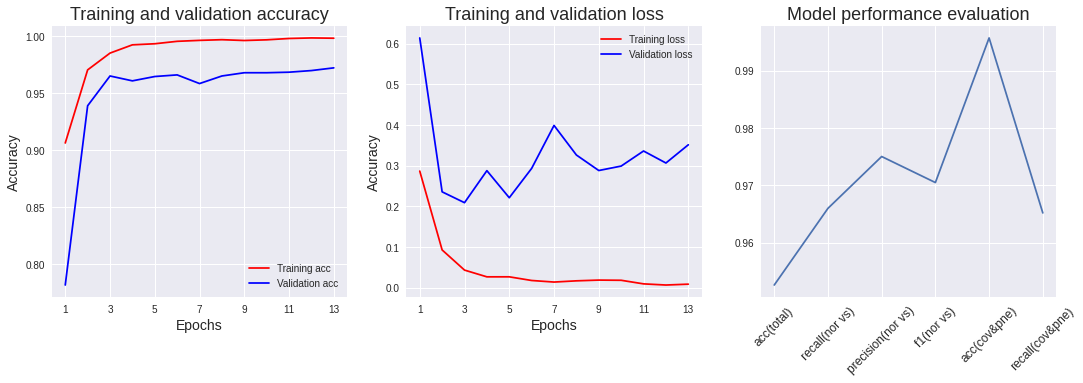

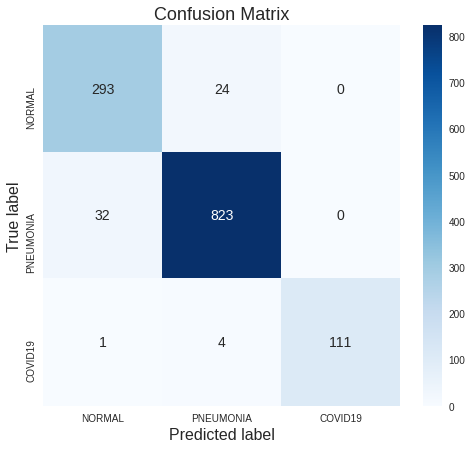

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Xception

xception = xception.Xception(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

xcep_model = models.Sequential(name="Xception")
xcep_model.add(xception)
xcep_model.add(layers.Flatten())
xcep_model.add(layers.Dense(4096, activation='relu'))
xcep_model.add(layers.Dense(512, activation='relu'))
xcep_model.add(layers.Dense(64, activation='relu'))
xcep_model.add(layers.Dense(3, activation='softmax'))

xcep_model.summary()

xcep_model.compile(loss='categorical_crossentropy', optimizer=optimizers.RMSprop(lr=2e-5), metrics=['acc'])

history = xcep_model.fit(train_data, 
                          train_label,
                          validation_split=0.2,
                          epochs=200,
                          callbacks=[earlystopping])

model_performance(xcep_model, history, test_data, test_label, 'Xception')

Model: "Inception"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 2, 2, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 4096)              33558528  
_________________________________________________________________
dense_5 (Dense)              (None, 512)               2097664   
_________________________________________________________________
dense_6 (Dense)              (None, 64)                32832     
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 195       
Total params: 57,492,003
Trainable params: 57,457,571
Non-trainable params: 34,432
________________________________________

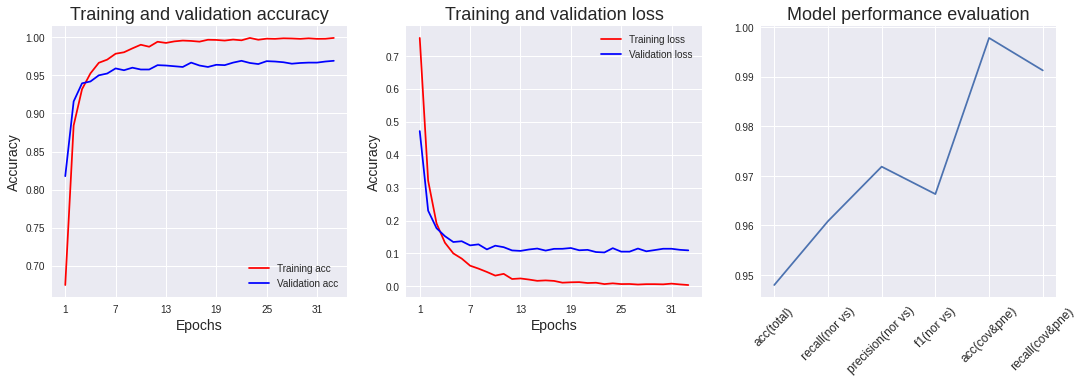

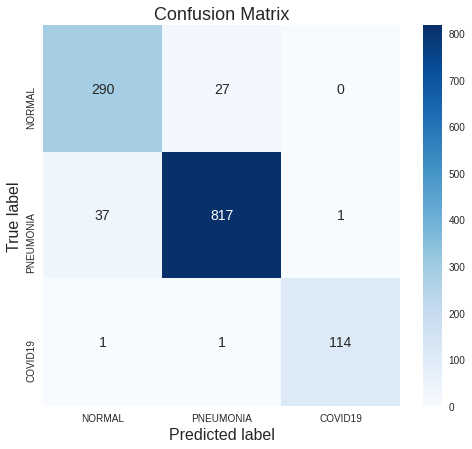

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
# inception

incep = InceptionV3(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

incep_model = models.Sequential(name='Inception')
incep_model.add(incep)
incep_model.add(layers.Flatten())
incep_model.add(layers.Dense(4096, activation='relu'))
incep_model.add(layers.Dense(512, activation='relu'))
incep_model.add(layers.Dense(64, activation='relu'))
incep_model.add(layers.Dense(3, activation='softmax'))

incep_model.summary()

incep_model.compile(loss='categorical_crossentropy', optimizer=optimizers.SGD(lr=0.001), metrics=['acc'])

history = incep_model.fit(train_data, 
                          train_label,
                          validation_split=0.2,
                          epochs=200,
                          callbacks=[earlystopping])

model_performance(incep_model, history, test_data, test_label, 'InceptionV3')

# 2. Ensemble

In [ ]:
def models_sum(mods, _data):

    for i, np in enumerate(mods):
        if i == 0:
            pred_val = np.predict(_data)
        else:
            pred_val += np.predict(_data)
    pred_val /= len(mods)

    return pred_val


def pred_models(mods, _data, _label):

    pred_val = models_sum(mods, _data)

    true_cl = [np.argmax(k) for k in _label]
    pred_cl = [np.argmax(j) for j in pred_val]

    return accuracy_score(true_cl, pred_cl), true_cl, pred_cl


def plt_heatmap(true_cl, pred_cl):

    index_list = ['NORMAL', 'PNEUMONIA', 'COVID19']
    cf = confusion_matrix(true_cl, pred_cl)
    cfdf = pd.DataFrame(cf, index=index_list, columns=index_list)
    sns.heatmap(cfdf, annot=True, cmap='Blues',
                fmt='d', annot_kws={"size": 14})
    plt.show()


def print_modelname(mods):
    for i in mods:
        if i == mods[-1]:
            print(i.name)
        else:
            print(i.name, end=", ")

3ConvLayer, VGG16, VGG19, AlexNet


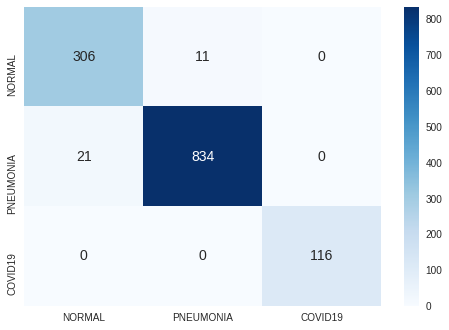

In [ ]:
mod_lists = [conv3_model, vgg16_model, vgg19_model, resnet34_model,
             resnet50_model, incep_model, alexnet_model, xcep_model, densenet50_model]

acc_before, acc_after = 0, 0
tr_list, pr_list, comb_list = [], [], []
for i in range(1, len(mod_lists)+1):
    for j in combinations(mod_lists, i):
        acc_after, tr, pr = pred_models(j, test_data, test_label)
        if acc_after >= acc_before:
            tr_list.append(tr)
            pr_list.append(pr)
            comb_list.append(j)
            acc_before = acc_after

acc2 = 0
for k in range(1, len(comb_list)):
    if accuracy_score(tr_list[-k], pr_list[-k]) >= acc2:
        print_modelname(comb_list[-k])
        plt_heatmap(tr_list[-k], pr_list[-k])
        acc2 = accuracy_score(tr_list[-k], pr_list[-k])
    else:
        break